# Modeling and Simulation in Python

Bungee jump case study

Copyright 2018 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Bungee jumping

Suppose you want to set the world record for the highest "bungee dunk", [as shown in this video](https://www.youtube.com/watch?v=UBf7WC19lpw).  Since the record is 70 m, let's design a jump for 80 m.

We'll make the following modeling assumptions:

1. Initially the bungee cord hangs from a crane with the attachment point 80 m above a cup of tea.

2. Until the cord is fully extended, it applies no force to the jumper.  It turns out this might not be a good assumption; we will revisit it.

3. After the cord is fully extended, it obeys [Hooke's Law](https://en.wikipedia.org/wiki/Hooke%27s_law); that is, it applies a force to the jumper proportional to the extension of the cord beyond its resting length.

4. The jumper is subject to drag force proportional to the square of their velocity, in the opposite of their direction of motion.

Our objective is to choose the length of the cord, `L`, and its spring constant, `k`, so that the jumper falls all the way to the tea cup, but no farther! 

First I'll create a `Param` object to contain the quantities we'll need:

1. Let's assume that the jumper's mass is 75 kg.

2. With a terminal velocity of 60 m/s.

3. The length of the bungee cord is `L = 40 m`.

4. The spring constant of the cord is `k = 20 N / m` when the cord is stretched, and 0 when it's compressed.


In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
N = UNITS.newton

<Unit('newton')>

In [3]:
params = Params(y_attach = 80 * m,
                 v_init = 0 * m / s,
                 g = 9.8 * m/s**2,
                 mass = 75 * kg,
                 area = 1 * m**2,
                 rho = 1.2 * kg/m**3,
                 v_term = 60 * m / s,
                 L = 25 * m,
                 k = 40 * N / m,
                 zero_force = 0 * N)

,values
y_attach,80 meter
v_init,0.0 meter / second
g,9.8 meter / second ** 2
mass,75 kilogram
area,1 meter ** 2
rho,1.2 kilogram / meter ** 3
v_term,60.0 meter / second
L,25 meter
k,40.0 newton / meter
zero_force,0 newton


Now here's a version of `make_system` that takes a `Params` object as a parameter.

`make_system` uses the given value of `v_term` to compute the drag coefficient `C_d`.

In [4]:
def make_system(params):
    """Makes a System object for the given params.
    
    params: Params object
    
    returns: System object
    """
    area, mass = params.area, params.mass
    g, rho = params.g, params.rho
    v_init, v_term = params.v_init, params.v_term
    y_attach = params.y_attach
    
    C_d = 2 * mass * g / (rho * area * v_term**2)
    init = State(y=y_attach, v=v_init)
    t_end = 20 * s

    return System(params, C_d=C_d, 
                  init=init, t_end=t_end)

Let's make a `System`

In [5]:
system = make_system(params)

,values
y_attach,80 meter
v_init,0.0 meter / second
g,9.8 meter / second ** 2
mass,75 kilogram
area,1 meter ** 2
rho,1.2 kilogram / meter ** 3
v_term,60.0 meter / second
L,25 meter
k,40.0 newton / meter
zero_force,0 newton


`spring_force` computes the force of the cord on the jumper.

If the spring is not extended, it returns `zero_force`, which is either 0 Newtons or 0, depending on whether the `System` object has units.  I did that so the slope function works correctly with and without units.

In [6]:
def spring_force(y, system):
    """Computes the force of the bungee cord on the jumper:
    
    y: height of the jumper
    
    Uses these variables from system|
    y_attach: height of the attachment point
    L: resting length of the cord
    k: spring constant of the cord
    
    returns: force in N
    """
    y_attach, L, k = system.y_attach, system.L, system.k
    
    distance_fallen = y_attach - y
    if distance_fallen <= L:
        return system.zero_force
    
    extension = distance_fallen - L
    f_spring = k * extension
    return f_spring

The spring force is 0 until the cord is fully extended.  When it is extended 1 m, the spring force is 40 N. 

In [7]:
spring_force(80*m, system)

0 <Unit('newton')>

In [8]:
spring_force(55*m, system)

0 <Unit('newton')>

In [9]:
spring_force(54*m, system)

40.0 <Unit('newton')>

`drag_force` computes drag as a function of velocity:

In [10]:
def drag_force(v, system):
    """Computes drag force in the opposite direction of `v`.
    
    v: velocity
    system: System object

    returns: drag force
    """
    rho, C_d, area = system.rho, system.C_d, system.area
    
    f_drag = -np.sign(v) * rho * v**2 * C_d * area / 2
    return f_drag

Here's the drag force at 60 meters per second.

In [11]:
v = -60 * m/s
f_drag = drag_force(v, system)

735.0 <Unit('kilogram * meter / second ** 2')>

Acceleration due to drag at 60 m/s is approximately g, which confirms that 60 m/s is terminal velocity.

In [12]:
a_drag = f_drag / system.mass

9.8 <Unit('meter / second ** 2')>

Now here's the slope function:

In [13]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    y, v = state
    mass, g = system.mass, system.g
    
    a_drag = drag_force(v, system) / mass
    a_spring = spring_force(y, system) / mass
    
    dvdt = -g + a_drag + a_spring
    
    return v, dvdt

As always, let's test the slope function with the initial params.

In [14]:
slope_func(system.init, 0, system)

(0.0 <Unit('meter / second')>, -9.8 <Unit('meter / second ** 2')>)

And then run the simulation.

In [15]:
results, details = run_ode_solver(system, slope_func, max_step=0.3)
details

,values
sol,None
t_events,[]
nfev,428
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


Here's the plot of position as a function of time.

In [16]:
def plot_position(results):
    plot(results.y)
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')

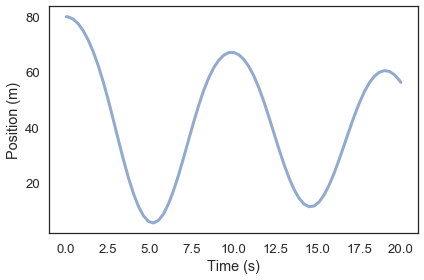

In [17]:
plot_position(results)

After reaching the lowest point, the jumper springs back almost to almost 70 m, and oscillates several times.  That looks like more osciallation that we expect from an actual jump, which suggests that there some dissipation of energy in the real world that is not captured in our model.  To improve the model, that might be a good thing to investigate.

But since we are primarily interested in the initial descent, the model might be good enough for now.

We can use `min` to find the lowest point:

In [18]:
min(results.y)

5.3987270041625965

At the lowest point, the jumper is still too high, so we'll need to increase `L` or decrease `k`.

Here's velocity as a function of time:

In [19]:
def plot_velocity(results):
    plot(results.v, color='C1', label='v')
        
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/s)')

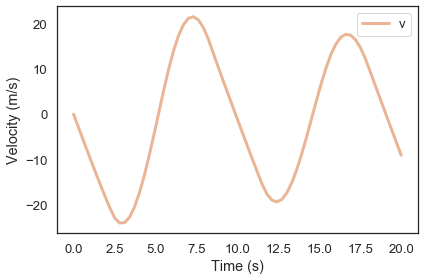

In [20]:
plot_velocity(results)

Although we compute acceleration inside the slope function, we don't get acceleration as a result from `run_ode_solver`.

We can approximate it by computing the numerical derivative of `ys`:

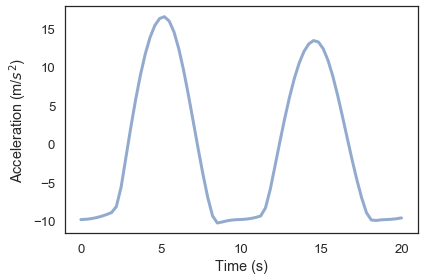

In [21]:
a = gradient(results.v)
plot(a)
decorate(xlabel='Time (s)',
         ylabel='Acceleration (m/$s^2$)')

And we can compute the maximum acceleration the jumper experiences:

In [22]:
max_acceleration = max(a) * m/s**2

16.51379192670322 <Unit('meter / second ** 2')>

Relative to the acceleration of gravity, the jumper "pulls" about "1.7 g's".

In [23]:
max_acceleration / system.g

1.6850808088472673 <Unit('dimensionless')>

### Under the hood

The gradient function in `modsim.py` adapts the NumPy function of the same name so it works with `Series` objects.


In [24]:
source_code(gradient)

def gradient(series):
    """Computes the numerical derivative of a series."""
    a = np.gradient(series, series.index)
    return TimeSeries(a, series.index)



### Solving for length

Assuming that `k` is fixed, let's find the length `L` that makes the minimum altitude of the jumper exactly 0.

The metric we are interested in is the lowest point of the first oscillation.  For both efficiency and accuracy, it is better to stop the simulation when we reach this point, rather than run past it and the compute the minimum.

Here's an event function that stops the simulation when velocity is 0.

In [25]:
def event_func(state, t, system):
    """Return velocity.
    """
    y, v = state
    return v

As usual, we should test it with the initial conditions.

In [26]:
event_func(system.init, 0, system)

0.0 <Unit('meter / second')>

And we see that we have a problem.  Since the event function returns 0 under the initial conditions, the simulation would stop immediately.  We can solve that problem by specifying the direction of the event function:

In [27]:
event_func.direction = +1

When direction is positive, it only stops the simulation if the velocity is 0 and increasing, which is what we want.

Now we can test it an confirm that it stops at the bottom of the jump.

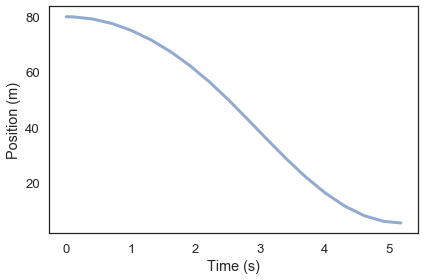

In [28]:
results, details = run_ode_solver(system, slope_func, events=event_func, max_step=0.3)
plot_position(results)

In [29]:
min(results.y)

5.3898136492074435

**Exercise:** Write an error function that takes `L` and `params` as arguments, simulates a bungee jump, and returns the lowest point.

Test the error function with a guess of 25 m and confirm that the return value is about 5 meters.

Use `root_scalar` with your error function to find the value of `L` that yields a perfect bungee dunk.  Hint: before calling `root_scalar`, make a version of `params` with no dimensions.

Run a simulation with the result from `root_scalar` and confirm that it works.

In [30]:
# Solution

def error_func(L, params):
    """Minimum height as a function of length.
    
    L: length in m
    params: Params object
    
    returns: height in m
    """
    params = Params(params, L=L)
    system = make_system(params)

    results, details = run_ode_solver(system, slope_func, events=event_func)
    min_height = get_last_value(results.y)
    return min_height

In [31]:
# Solution

error_func(25, params)

5.175384394959764

In [32]:
# Solution

error_func(30, params)

-1.6054918701259555

In [33]:
# Solution

params_no_dim = remove_units(params)
res = root_scalar(error_func, [25, 30], params_no_dim)

      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 28.724145955383168

In [34]:
# Solution

L = res.root * m
params_solution = Params(params, L=L)
system_solution = make_system(params_solution)

results, details = run_ode_solver(system_solution, slope_func, events=event_func)
details

,values
sol,None
t_events,[[5.297215568490456]]
nfev,80
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [35]:
# Solution

min_height = get_last_value(results.y) * m

-1.7574483535121033e-13 <Unit('meter')>